# Code for making predictions with and without news features

## Libraries/Data required

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, mean_absolute_error, r2_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer


# Import models
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

data_dir = "data/" # Define data path

In [2]:
df = pd.read_csv(data_dir + "food_crises_cleaned.csv") # Read data into DataFrame
df["date"] = pd.to_datetime(df["year_month"], format="%Y_%m") # Create date column
print(len(df['district'].unique()))
df.set_index(["date", "district"], inplace=True) # Set index

78


## Basic visualizations

<br>
A bar chart showing the frequency of the different "fews_ipc" phases.

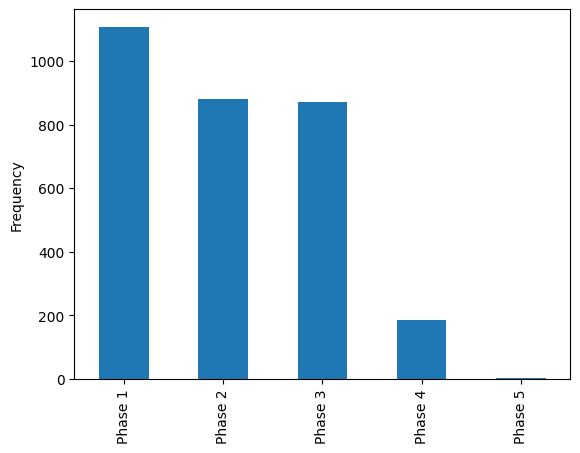

In [3]:
ax = df["ipc"].value_counts().plot(kind="bar") # Initialize barplot of fews_ipc counts
ax.set_xticklabels(["Phase {}".format(i) for i in range(1, 6)]) # Label the phases
ax.set_ylabel('Frequency'); # Set y label

<br>
A map of South Sudan showing the mean IPC per county (with geopandas).

/tmp/ipykernel_54076/480331542.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres")) # Get map of the world


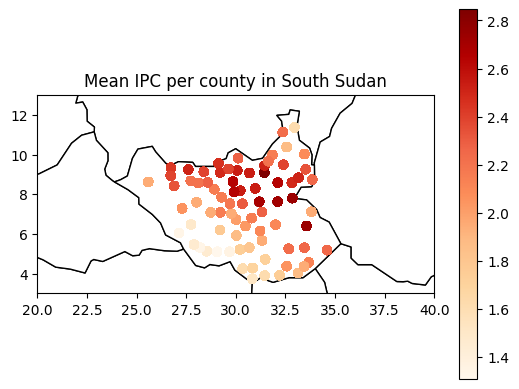

In [4]:
# Plot map of south sudan
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres")) # Get map of the world

ax = world.plot(color="white", edgecolor="black") # Plot world map

# Bound map to south sudan
ax.set_xlim(20, 40)
ax.set_ylim(3, 13)

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["centx"], df["centy"])) # Initialize GeoDataFrame

# Calculate mean ipc per administration
mean_ipc = (
    df.reset_index()[["ipc", "district"]]
    .groupby("district")
    .mean()
    .rename(columns={"ipc": "mean_ipc"})
)

# Plot mean ipc per administration on map
gdf.merge(mean_ipc, on="district").plot(
    column="mean_ipc", ax=ax, legend=True, cmap="OrRd"
)

# Set plot title
ax.set_title("Mean IPC per county in South Sudan");

<BR>

## Helper Functions

Here we define a function that lags input variables. There are options for creating a rolling mean, taking the difference between subsequent rows, and dropping NaNs. Feature engineering can of course be extended much further than this.

In [5]:
def create_lag_df(df, columns, lag, difference=False, rolling=None, dropna=False):
    '''
    Function to add lagged colums to dataframe
    
    Inputs:
        df - Dataframe
        columns - List of columns to create lags from
        lag - The number of timesteps (in months for the default data) to lag the variable by
        difference - Whether to take the difference between each observation as new column
        rolling - The size of the rolling mean window, input None type to not use a rolling variable
        dropna - Whether to drop NaN values
        
    Output:
        df - Dataframe with the lagged columns added
    '''
    
    for column in columns:
        col = df[column].unstack()
        if rolling:
            col = col.rolling(rolling).mean()
        if difference:
            col = col.diff()
        if dropna:
            col = col.dropna(how='any')
        df[f"{column}_lag_{lag}"] = col.shift(lag).stack()
    return df

<br>
Here we define a function that plots a confusion matrix given a prediction and the true values, it can be used both for binary and categorical variables.

In [6]:
def plot_ConfusionMatrix(prediction, true, binary=False):
    '''
    Function to plot a confusion matrix as a heatmap from a prediction and true values.
    
    Inputs:
        prediction - The predicted values
        true - the true values
        binary - whether the variable is binary or not
        
    Output:
        confusion_matrix - The calculated confusion matrix based on the prediction and true values.
        
        Also plots the confusion matrix as heatmap in an interactive environment such as Jupyter Notebook.
    '''
    
    y_pred = prediction
    
    if not binary:
        # Round prediction to nearest integer (i.e. the nearest phase)
        y_pred = y_pred.round() 
        y_pred = np.minimum(y_pred, 5) # Cap maximum prediction at 5 (maximum phase)
        y_pred = np.maximum(y_pred, 1) # Cap minimum prediction at 1 (minimum phase)

    # Initialize confusion matrix
    confusion_matrix = pd.crosstab(
        true, y_pred, rownames=["Actual"], colnames=["Predicted"]
    )

    # Plot confusion matrix as heatmap
    sns.heatmap(confusion_matrix, annot=True, fmt="g")
    plt.show()
    plt.clf()
    
    return confusion_matrix

## Making Predictions

To simplify, we treat the IPC prediction problem as regression rather than classification,
e.g., multivariable logistic regression might be more suited.
<br><br>
We use a TimeSeriesSplit to divide the data into 5 training-test splits and run cross-validation on these splits. 
<br>We report the confusion matrix (with training and test split as title) along with the model summary per split; the mean MAE and mean R2 are reported after completion of cross-validation.
<br><br>
First however, we create multiple lagged variables in the cell directly below.

In [7]:
# Create several lagged columns to use as explanatory variables for the model

df = create_lag_df(df, ['count_violence', 'ndvi_anom'], 3, rolling=6) # 3-month-lagged rolling mean window of size 6
df = create_lag_df(df, ['food_price_idx'], 3, difference=True, rolling=6) # difference of the 3-month-lagged rolling mean window of size 6
df = create_lag_df(df, ['ipc'], 1, dropna=True) # 1-month-lag
df = create_lag_df(df, ['ipc'], 2, dropna=True) # 2-month-lag
df = create_lag_df(df, ['ipc'], 3, dropna=True) # 3-month-lag

df.columns, len(df.columns) # View the newly created columns

(Index(['country', 'district_code', 'centx', 'centy', 'year_month', 'year',
        'month', 'ipc', 'ha', 'ndvi_mean', 'ndvi_anom', 'rain_mean',
        'rain_anom', 'et_mean', 'et_anom', 'count_violence', 'sum_fatalities',
        'food_price_idx', 'area', 'cropland_pct', 'pop', 'ruggedness_mean',
        'pasture_pct', 'count_violence_lag_3', 'ndvi_anom_lag_3',
        'food_price_idx_lag_3', 'ipc_lag_1', 'ipc_lag_2', 'ipc_lag_3'],
       dtype='object'),
 29)

In [8]:
df.sort_index(level=0, inplace=True) # Sort DataFrame by date
df = df.iloc[df['ipc'].notnull().argmax():].copy() # Drop rows until first notna value in ipc column

                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.627
Model:                            OLS   Adj. R-squared:                  0.622
Method:                 Least Squares   F-statistic:                     132.8
Date:                Tue, 24 Oct 2023   Prob (F-statistic):          1.58e-193
Time:                        16:56:14   Log-Likelihood:                -288.10
No. Observations:                 962   AIC:                             602.2
Df Residuals:                     949   BIC:                             665.5
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    1.8137 

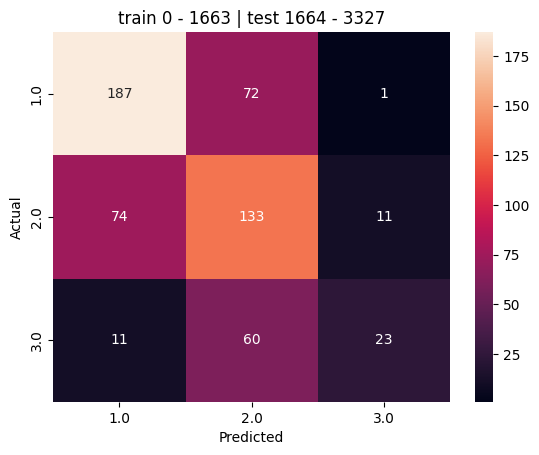

                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.586
Method:                 Least Squares   F-statistic:                     310.6
Date:                Tue, 24 Oct 2023   Prob (F-statistic):               0.00
Time:                        16:56:14   Log-Likelihood:                -1414.6
No. Observations:                2626   AIC:                             2855.
Df Residuals:                    2613   BIC:                             2931.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.9661 

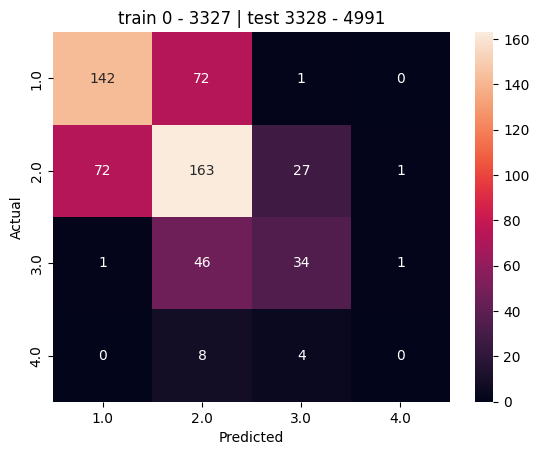

                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.586
Method:                 Least Squares   F-statistic:                     507.6
Date:                Tue, 24 Oct 2023   Prob (F-statistic):               0.00
Time:                        16:56:15   Log-Likelihood:                -2482.1
No. Observations:                4290   AIC:                             4990.
Df Residuals:                    4277   BIC:                             5073.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -1.0145 

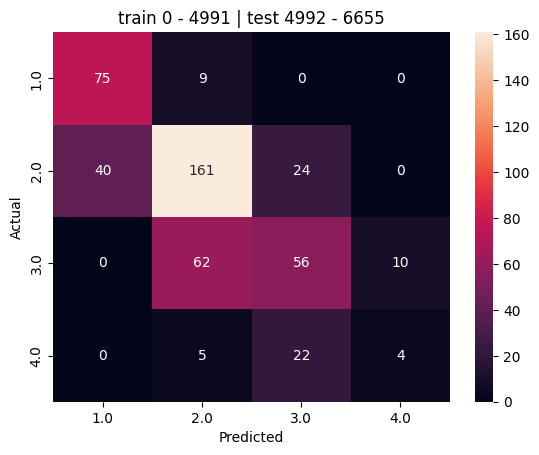

                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.664
Model:                            OLS   Adj. R-squared:                  0.664
Method:                 Least Squares   F-statistic:                     980.2
Date:                Tue, 24 Oct 2023   Prob (F-statistic):               0.00
Time:                        16:56:15   Log-Likelihood:                -3415.9
No. Observations:                5954   AIC:                             6858.
Df Residuals:                    5941   BIC:                             6945.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.9042 

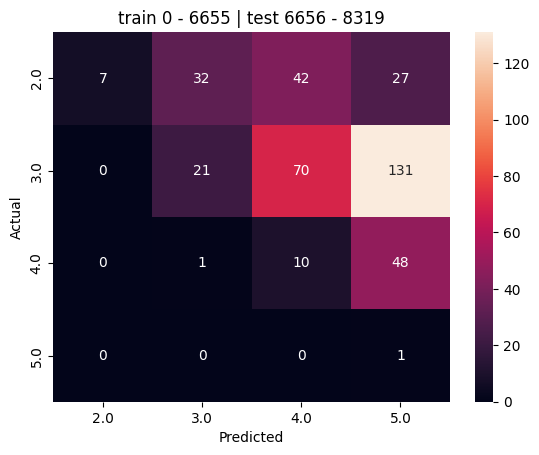

                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.714
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                     1585.
Date:                Tue, 24 Oct 2023   Prob (F-statistic):               0.00
Time:                        16:56:16   Log-Likelihood:                -4634.7
No. Observations:                7618   AIC:                             9295.
Df Residuals:                    7605   BIC:                             9386.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.7676 

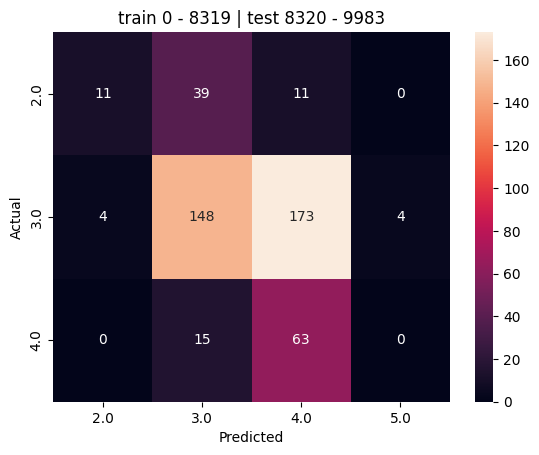

Mean MAE: 0.71
Mean R2: 0.64


<Figure size 640x480 with 0 Axes>

In [9]:
X = df.iloc[:, -12:] # Define explanatory variables
X = sm.add_constant(X) # Add constant column of 1s for intercept
y = df[["ipc"]] # Define target data

cv = TimeSeriesSplit(n_splits=5) # Define TimeSeriesSplit with 5 splits

# Initinalize empty lists to score scores
mae_values = list()
r2_values = list()

for train_index, val_index in cv.split(X): # Loop over the different training-test splits

    # Define X and y data
    X_train, X_test = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    #Interpolate training data to generate more training points
    X_train = X_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    X_train.reset_index(level=0, drop=True, inplace=True)
    y_train = y_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    y_train.reset_index(level=0, drop=True, inplace=True)

    model = OLS(y_train, X_train, missing="drop") # Initialize OLS model on training data
    results = model.fit() # Get model results on training data
    print(results.summary()) # Print model summary

    y_pred = results.predict(X_test) # Run model on test data
    
    # Append results to respective lists
    mae_values.append((y_pred - y_val['ipc']).abs().mean())
    r2_values.append(results.rsquared)
    
    plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
    plot_ConfusionMatrix(prediction = y_pred, true = y_val['ipc']) # Plot confusion matrix
    
print(f"Mean MAE: {np.mean(mae_values):.2f}") # Print MAE
print(f"Mean R2: {np.mean(r2_values):.2f}") # Print R2

## Incorporating News Features

We look at country wide news features to simplify. E.g., we do not look at topics per district

In [10]:
news_df = pd.read_csv(data_dir + "articles_topics_original.csv") # Read news data into DataFrame

# Create date column
news_df["date"] = pd.to_datetime(
    pd.to_datetime(news_df["date"], format="%Y-%m-%d").dt.strftime("%Y-%m"),
    format="%Y-%m",
)

In [11]:
def create_news_features(columns):
    cols = []
    for column in columns:
        col = news_df.groupby(["date"])[column].mean()
        col = col.fillna(0)
        col = col.rolling(3).mean()
        col = col.shift(3)
        cols.append(col)
    return pd.concat(cols, axis=1)

### Visualization of news features over time

The 2017 South Sudan famine is very apparent. Most of this event needs to be predicted out-of-sample with the training/test split we chose.

More info on the famine : https://en.wikipedia.org/wiki/2017_South_Sudan_famine

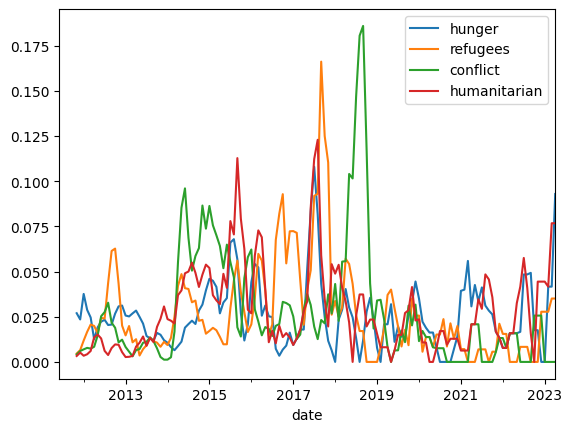

In [12]:
# country wide news features
news_features = create_news_features(["hunger", 'refugees', 'conflict', 'humanitarian'])

news_features.plot();

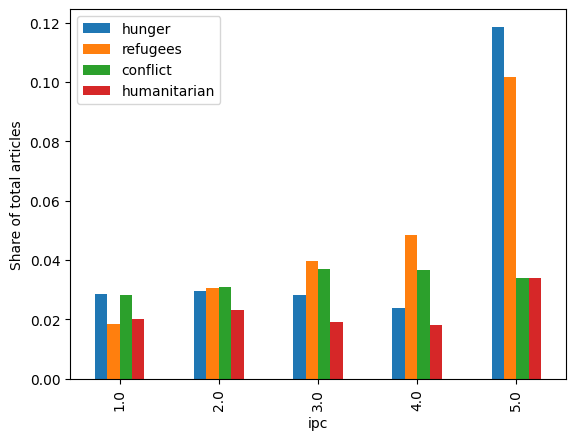

In [13]:
# Get the mean share of articles per ipc for the different topics
combined = (
    pd.DataFrame(y['ipc'])
    .join(news_df.groupby(["date"])["hunger"].mean())
    .join(news_df.groupby(["date"])["refugees"].mean())
    .join(news_df.groupby(["date"])["conflict"].mean())
    .join(news_df.groupby(["date"])["humanitarian"].mean())
)


# Plot the mean share of articles per ipc value for the different topics
combined.groupby("ipc")[["hunger", "refugees", "conflict", "humanitarian"]].mean().plot(
    kind="bar", ylabel="Share of total articles"
);

## Predicting using news features

In [14]:
df.sort_index(level=0, inplace=True) # Sort DataFrame by date
df = df.iloc[df['ipc'].notnull().argmax():].copy() # Drop rows until first notna value in ipc column
df = df.join(news_features, how="left") # Join df with created news features

                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     258.4
Date:                Tue, 24 Oct 2023   Prob (F-statistic):          4.40e-196
Time:                        17:39:07   Log-Likelihood:                -298.28
No. Observations:                 962   AIC:                             610.6
Df Residuals:                     955   BIC:                             644.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    1.8493 

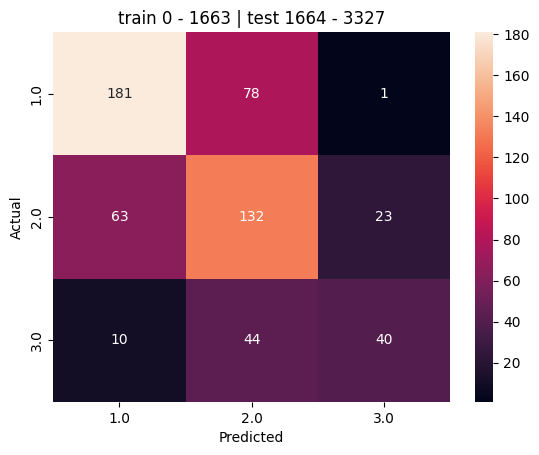

                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.677
Model:                            OLS   Adj. R-squared:                  0.675
Method:                 Least Squares   F-statistic:                     238.0
Date:                Tue, 24 Oct 2023   Prob (F-statistic):          3.76e-270
Time:                        17:39:08   Log-Likelihood:                -576.01
No. Observations:                1144   AIC:                             1174.
Df Residuals:                    1133   BIC:                             1229.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -1.4708 

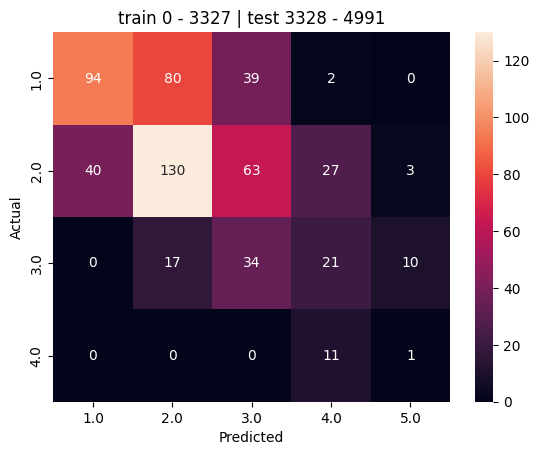

                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.615
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                     445.9
Date:                Tue, 24 Oct 2023   Prob (F-statistic):               0.00
Time:                        17:39:09   Log-Likelihood:                -1660.0
No. Observations:                2808   AIC:                             3342.
Df Residuals:                    2797   BIC:                             3407.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.1257 

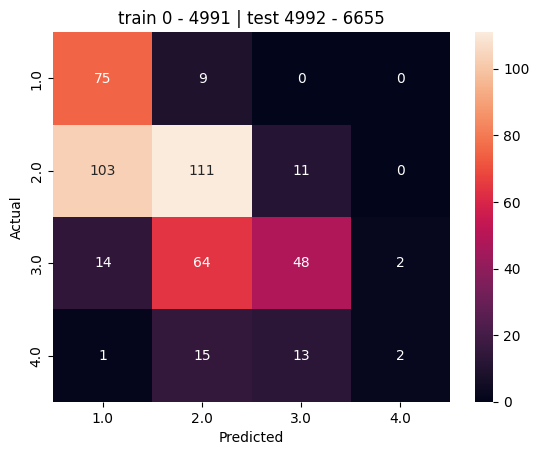

                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.662
Model:                            OLS   Adj. R-squared:                  0.662
Method:                 Least Squares   F-statistic:                     875.4
Date:                Tue, 24 Oct 2023   Prob (F-statistic):               0.00
Time:                        17:39:09   Log-Likelihood:                -2732.5
No. Observations:                4472   AIC:                             5487.
Df Residuals:                    4461   BIC:                             5558.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.2999 

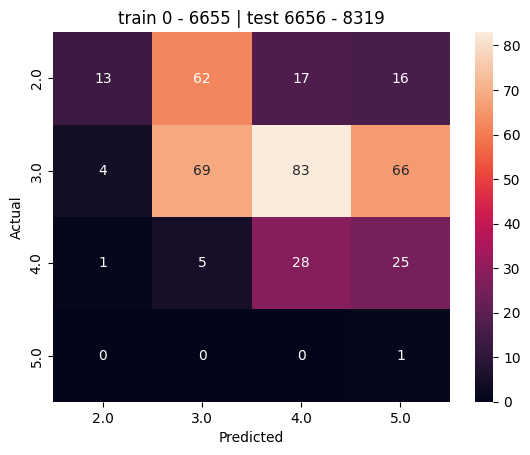

                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.703
Method:                 Least Squares   F-statistic:                     1452.
Date:                Tue, 24 Oct 2023   Prob (F-statistic):               0.00
Time:                        17:39:10   Log-Likelihood:                -3915.8
No. Observations:                6136   AIC:                             7854.
Df Residuals:                    6125   BIC:                             7927.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.1074 

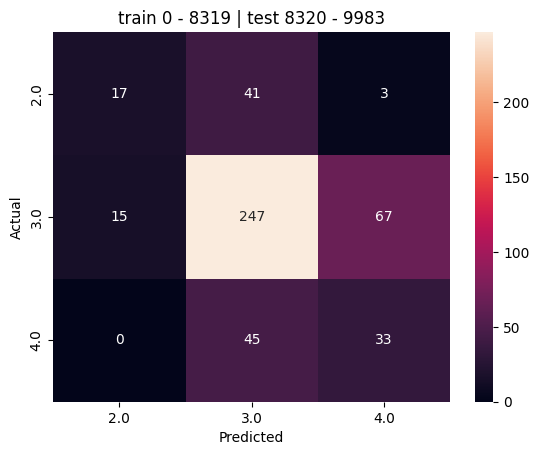

Mean MAE: 0.69
Mean R2: 0.66


<Figure size 640x480 with 0 Axes>

In [32]:
X = df.iloc[:, -10:] # Define explanatory variables
X = sm.add_constant(X) # Add constant column of 1s for intercept
y = df[["ipc"]] # Define target data

cv = TimeSeriesSplit(n_splits=5) # Define TimeSeriesSplit with 5 splits

# Initinalize empty lists to score scores
mae_values = list()
r2_values = list()

for train_index, val_index in cv.split(X): # Loop over the different training-test splits

    # Define X and y data
    X_train, X_test = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # If X_train doesn't contain any news features (this happens for earlier dates) we drop news columns from both X_train and X_test
    X_train = X_train.dropna(axis=1, how='all').copy()
    X_test = X_test[X_train.columns]
    
    #Interpolate training data to generate more training points
    X_train = X_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    X_train.reset_index(level=0, drop=True, inplace=True)
    y_train = y_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    y_train.reset_index(level=0, drop=True, inplace=True)

    model = OLS(y_train, X_train, missing="drop") # Initialize OLS model on training data
    results = model.fit() # Get model results on training data
    print(results.summary()) # Print model summary

    y_pred = results.predict(X_test) # Run model on test data
    
    # Append results to respective lists
    mae_values.append((y_pred - y_val['ipc']).abs().mean())
    r2_values.append(results.rsquared)

    plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
    plot_ConfusionMatrix(prediction = y_pred, true = y_val['ipc']) # Plot confusion matrix
    
print(f"Mean MAE: {np.mean(mae_values):.2f}") # Print MAE
print(f"Mean R2: {np.mean(r2_values):.2f}") # Print R2

We see that the R2 has risen somewhat compared to the baseline.

### Predicting crisis/no crisis

We can also transform the IPC prediction in a binary classification problem by considering IPC 3+ as crisis, and IPC 2- as no-crisis. Let's give a simple example

In [16]:
df.sort_index(level=0, inplace=True) # Sort DataFrame by date
df = df.iloc[df['ipc'].notnull().argmax():].copy() # Drop rows until first notna value in ipc column

Optimization terminated successfully.
         Current function value: 0.023951
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:                    ipc   No. Observations:                  962
Model:                          Logit   Df Residuals:                      958
Method:                           MLE   Df Model:                            3
Date:                Tue, 24 Oct 2023   Pseudo R-squ.:                  0.7213
Time:                        16:56:20   Log-Likelihood:                -23.041
converged:                       True   LL-Null:                       -82.676
Covariance Type:            nonrobust   LLR p-value:                 1.108e-25
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -16.9214      2.560     -6.610      0.000     -21.939     -11.904
ipc_lag_1      7.5452      1

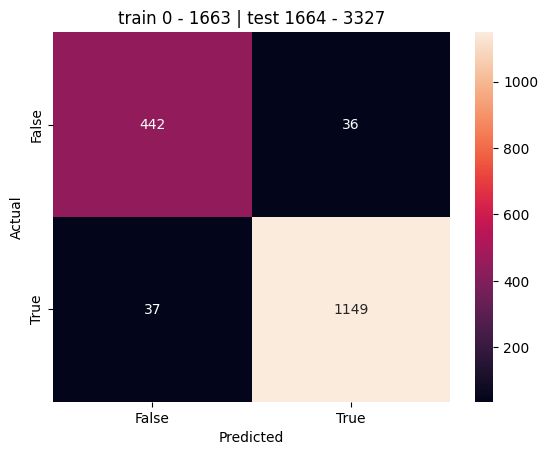

Optimization terminated successfully.
         Current function value: 0.196510
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                    ipc   No. Observations:                 2626
Model:                          Logit   Df Residuals:                     2622
Method:                           MLE   Df Model:                            3
Date:                Tue, 24 Oct 2023   Pseudo R-squ.:                  0.4129
Time:                        16:56:21   Log-Likelihood:                -516.04
converged:                       True   LL-Null:                       -878.95
Covariance Type:            nonrobust   LLR p-value:                5.241e-157
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.0771      0.344    -23.471      0.000      -8.752      -7.403
ipc_lag_1      3.0044      0.

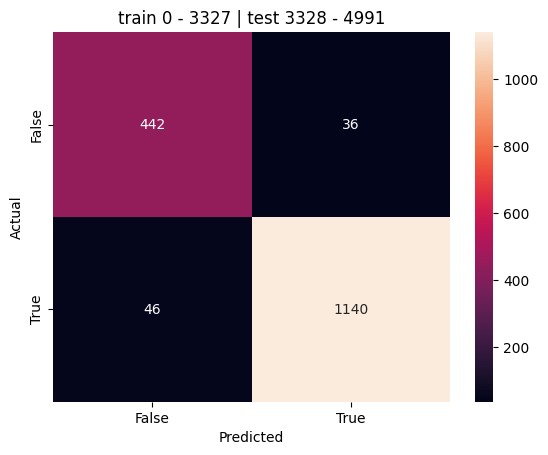

Optimization terminated successfully.
         Current function value: 0.220939
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                    ipc   No. Observations:                 4290
Model:                          Logit   Df Residuals:                     4286
Method:                           MLE   Df Model:                            3
Date:                Tue, 24 Oct 2023   Pseudo R-squ.:                  0.3941
Time:                        16:56:22   Log-Likelihood:                -947.83
converged:                       True   LL-Null:                       -1564.4
Covariance Type:            nonrobust   LLR p-value:                4.853e-267
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -7.8526      0.262    -29.949      0.000      -8.367      -7.339
ipc_lag_1      2.9520      0.

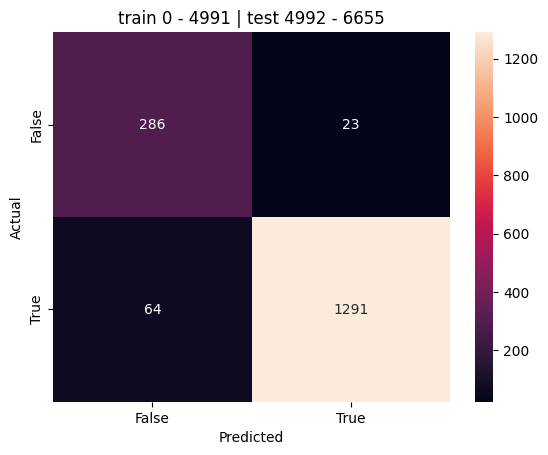

Optimization terminated successfully.
         Current function value: 0.263542
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                    ipc   No. Observations:                 5954
Model:                          Logit   Df Residuals:                     5950
Method:                           MLE   Df Model:                            3
Date:                Tue, 24 Oct 2023   Pseudo R-squ.:                  0.4349
Time:                        16:56:22   Log-Likelihood:                -1569.1
converged:                       True   LL-Null:                       -2776.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -7.8860      0.209    -37.780      0.000      -8.295      -7.477
ipc_lag_1      2.8618      0.

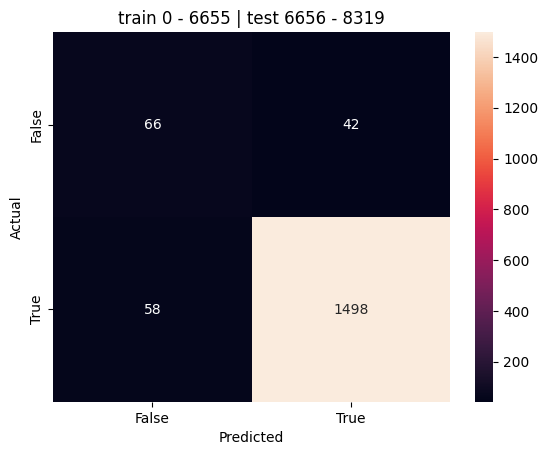

Optimization terminated successfully.
         Current function value: 0.297659
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                    ipc   No. Observations:                 7618
Model:                          Logit   Df Residuals:                     7614
Method:                           MLE   Df Model:                            3
Date:                Tue, 24 Oct 2023   Pseudo R-squ.:                  0.5120
Time:                        16:56:23   Log-Likelihood:                -2267.6
converged:                       True   LL-Null:                       -4646.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.2706      0.182    -45.491      0.000      -8.627      -7.914
ipc_lag_1      2.6647      0.

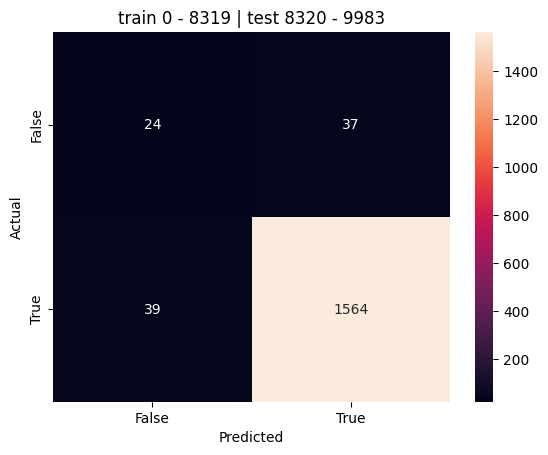

Mean Acc: 0.95


<Figure size 640x480 with 0 Axes>

In [17]:
X = df.iloc[:, -16:] # Define explanatory variables
X = sm.add_constant(X) # Add constant column of 1s for intercept
y = df[["ipc"]] # Define target data

cv = TimeSeriesSplit(n_splits=5) # Define TimeSeriesSplit with 5 splits
acc_values = list() # Initinalize empty lists to score accuracy scores

for train_index, val_index in cv.split(X): # Loop over the different training-test splits
    
    y_binary = y > 2 # Convert y to binary variable
    y_binary[y.isna()] = pd.NA # Conserve NaN values
    y_binary = y_binary.astype("float32") # Convert y to float

    # Define X and y data
    X_train, X_test = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y_binary.iloc[train_index], y_binary.iloc[val_index]
    
    #Interpolate training data to generate more training points
    X_train = X_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    X_train.reset_index(level=0, drop=True, inplace=True)
    y_train = y_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    y_train.reset_index(level=0, drop=True, inplace=True)
    
    cols = ['const', 'ipc_lag_1', 'ipc_lag_2', 'ipc_lag_3'] # Select columns to use in model
    model = sm.Logit(y_train, X_train[cols], missing="drop") # Initialize Logit model
    results = model.fit() # Get model results on training data
    print(results.summary()) # Print model summary

    y_pred = results.predict(X_test[cols]) # Run model on test data

    # Convert prediction and validation to boolean
    y_pred = y_pred.round().astype(bool)
    y_val = y_val.round().astype(bool)

    # Drop all rows from prediction and validation where validation is null
    y_pred = y_pred[list(y_val.isnull()['ipc']==False)]
    y_val.dropna(inplace=True)

    acc_values.append(accuracy_score(y_val, y_pred)) # Append accuracy to list

    plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
    plot_ConfusionMatrix(prediction = y_pred, true = y_val['ipc'], binary = True) # Plot confusion matrix
    
print(f"Mean Acc: {np.mean(acc_values):.2f}") # Print Acc

<Axes: >

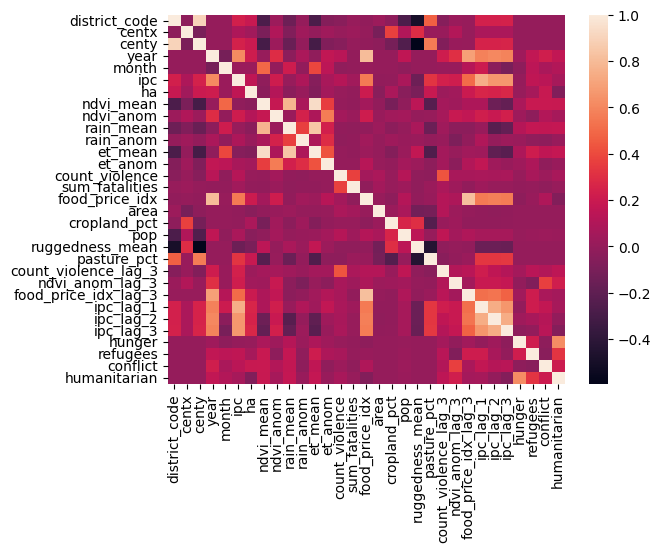

In [18]:
corr = df.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

In [19]:
df.head(20)

country  district_code     centx     centy  \
date       district                                                       
2009-07-01 Abiemnhom     South Sudan            136  29.13019  9.550939   
           Akobo         South Sudan            114  32.85308  7.799214   
           Anzara        South Sudan             86  28.20598  5.309739   
           Aweil Center  South Sudan            128  26.89562  8.417934   
           Aweil East    South Sudan            141  27.61364  9.243139   
           Aweil North   South Sudan             76  26.72969  9.334756   
           Aweil South   South Sudan            126  27.73611  8.667977   
           Aweil West    South Sudan            132  26.72393  8.930423   
           Awerial       South Sudan             99  31.22946  6.150162   
           Ayod          South Sudan            124  30.98072  8.291426   
           Baliet        South Sudan            146  32.40192  9.490525   
           Bor           South Sudan             74  32.00486  6.465644   
           Budi          South Sudan             88  33.44930  4.357813   
           Cueibet       South Sudan            110  29.22492  7.082292   
           Duk           South Sudan            116  31.18647  7.617574   
           Ezo           South Sudan             96  27.89410  5.460567   
           Fangak        South Sudan            138  30.68803  9.071977   
           Fashoda       South Sudan            147  31.84424  9.980295   
           Gogrial East  South Sudan            129  28.58906  8.597443   
           Gogrial West  South Sudan            131  28.10997  8.567440   

                        year_month  year  month  ipc  ha  ndvi_mean  ...  \
date       district                                                  ...   
2009-07-01 Abiemnhom       2009_07  2009      7  2.0 NaN   0.698165  ...   
           Akobo           2009_07  2009      7  4.0 NaN   0.474723  ...   
           Anzara          2009_07  2009      7  1.0 NaN   0.812001  ...   
           Aweil Center    2009_07  2009      7  2.0 NaN   0.723154  ...   
           Aweil East      2009_07  2009      7  3.0 NaN   0.547611  ...   
           Aweil North     2009_07  2009      7  2.0 NaN   0.575884  ...   
           Aweil South     2009_07  2009      7  2.0 NaN   0.570958  ...   
           Aweil West      2009_07  2009      7  2.0 NaN   0.632353  ...   
           Awerial         2009_07  2009      7  1.0 NaN   0.627020  ...   
           Ayod            2009_07  2009      7  2.0 NaN   0.546399  ...   
           Baliet          2009_07  2009      7  2.0 NaN   0.518939  ...   
           Bor             2009_07  2009      7  2.0 NaN   0.515550  ...   
           Budi            2009_07  2009      7  2.0 NaN   0.480712  ...   
           Cueibet         2009_07  2009      7  1.0 NaN   0.698681  ...   
           Duk             2009_07  2009      7  2.0 NaN   0.565912  ...   
           Ezo             2009_07  2009      7  1.0 NaN   0.808912  ...   
           Fangak          2009_07  2009      7  1.0 NaN   0.643817  ...   
           Fashoda         2009_07  2009      7  1.0 NaN   0.631213  ...   
           Gogrial East    2009_07  2009      7  3.0 NaN   0.639864  ...   
           Gogrial West    2009_07  2009      7  3.0 NaN   0.566646  ...   

                         count_violence_lag_3  ndvi_anom_lag_3  \
date       district                                              
2009-07-01 Abiemnhom                 0.000000        95.891380   
           Akobo                     0.333333       111.870073   
           Anzara                    0.000000       103.035443   
           Aweil Center              0.000000       106.495113   
           Aweil East                0.000000       102.086478   
           Aweil North               0.000000       100.543125   
           Aweil South               0.000000       104.309842   
           Aweil West                0.000000       106.059053   
           Awerial                   0.000000

In [20]:
#X_train.dropna()
#y_train.dropna()

#imputer = SimpleImputer(strategy='mean')
#X_train = imputer.fit_transform(X_train)
#y_train = imputer.fit_transform(y_train)

#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)

In [21]:
#skl_model = LogisticRegression()
#skl_model.fit(X_train, y_train)
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: pip install --upgrade pip


In [22]:
import xgboost as xg

#GPT
# Convert regression targets into classes based on a threshold
threshold = 0.5  # Adjust this threshold as needed
y_train_class = (y_train > threshold).astype(int)
y_val_class = (y_val > threshold).astype(int)
#GPT

dtrain = xg.DMatrix(X_train, label=y_train)
dtest = xg.DMatrix(X_test, label=y_val)

In [23]:
params = {'objective': 'reg:squarederror', 'max_depth': 2, 'learning_rate': 0.01, 'eta' : 0.7}
num_round = 10
model = xg.train(params, dtrain, num_round)

#GPT
y_pred_proba = model.predict(dtest)
y_pred_class = (y_pred_proba > threshold).astype(int)
y_train_pred_proba = model.predict(dtrain)
y_train_pred_class = (y_train_pred_proba > threshold).astype(int)

In [24]:
print(classification_report(y_val_class, y_pred_class))

              precision    recall  f1-score   support

           0       0.04      1.00      0.07        61
           1       0.00      0.00      0.00      1603

    accuracy                           0.04      1664
   macro avg       0.02      0.50      0.04      1664
weighted avg       0.00      0.04      0.00      1664



/home/egor/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/egor/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/egor/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
print(f"Mean Absolute Error:", mean_absolute_error(y_val, y_pred_class))
print(f"R-squared:", r2_score(y_val_class, y_pred_class))

Mean Absolute Error: 0.9633413461538461
R-squared: -26.278688524590166


In [26]:
# Calculate R2 on the training data
print(f"R-squared (Training):", r2_score(y_train_class, y_train_pred_class))

R-squared (Training): -0.3908391842193246


In [27]:
# Calculate and display the confusion matrix
conf_matrix = confusion_matrix(y_val_class, y_pred_class)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[  61    0]
 [1603    0]]


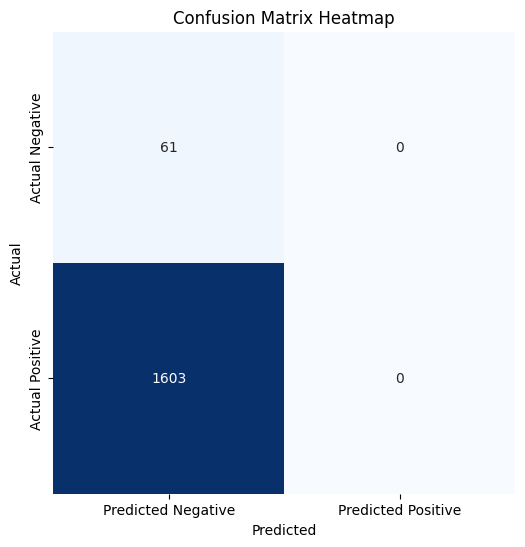

In [28]:
#GPT
# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, square=True,
            xticklabels=["Predicted Negative", "Predicted Positive"],
            yticklabels=["Actual Negative", "Actual Positive"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

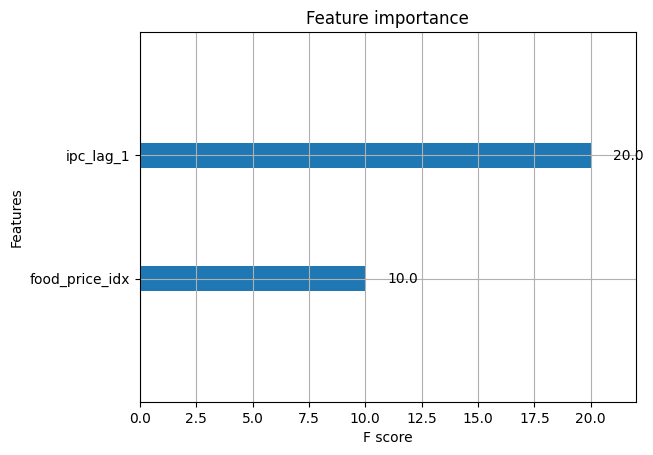

In [29]:
xg.plot_importance(model)
plt.show()